# Wind power expansion in Quebec: average capacity factors

We used data of hourly production of wind to calculate the availability factors. The data comes from the Pan-Canadian Wind Integration Study (PCWIS) and it can be downloaded in the [Canwea website](http://canwea.ca/wind-integration-study/wind-data/). (35% target, actual data)

## import libraries and setup plotting style

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SIZE)                # controls default text sizes
plt.rc('axes', titlesize=SIZE)           # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)          # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)          # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)          # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('seaborn-deep')

# witdth of figures
smallwidth=3.54
mediumwidth=5.51
bigwidth=7.48

## Analyse metadata

In [3]:
metadata=pd.read_excel('35TRGT_2008-2010_Actual/CanWEA_Wind_Site_Metadata.xlsx',sheetname='Metadata')

In [4]:
metadata['Site ID #']=metadata['Site ID #'].astype(str).str.zfill(4) # format site ID

In [5]:
metadata.shape

(4984, 18)

The Pan-Canadian study considered 4984 locations. 53 of them are used to describe the high penetration scenario in Quebec.

In [6]:
metadata.loc[(metadata['Province']=='Quebec'),['5BAU Scenario',
                                               '20DISP Scenario',
                                               '20CONC Scenario',
                                               '35TRGT Scenario']].sum()

5BAU Scenario      28
20DISP Scenario    40
20CONC Scenario    16
35TRGT Scenario    53
dtype: int64

In [7]:
metadata.head(3)

,Site ID #,Number of Grid Cells,Capacity (MW),Gross Energy (GWh),Maintenance Losses (GWh),Electrical Losses (GWh),Net Energy (GWh),Capacity Factor (%),Longitude,Latitude,Province,Onshore or Offshore,Dist to High Volt Transmission,5BAU Scenario,20DISP Scenario,20CONC Scenario,35TRGT Scenario,PCWIS Scalar
0,0001,2,32,108.621663,5.431083,3.095717,100.094862,0.357074,-82.279000,42.172150,Ontario,Onshore,25 km,0,0,0,0,0.000000
1,0002,2,32,113.677474,5.683874,3.239808,104.753792,0.373694,-81.945000,42.263450,Ontario,Onshore,25 km,0,0,0,0,0.000000
2,0003,8,128,449.030320,22.451516,12.797364,413.781440,0.369026,-82.111375,42.253462,Ontario,Onshore,25 km,1,0,0,0,1.003125


Average capacity factor in Quebec:

In [8]:
metadata.loc[(metadata['Province']=='Quebec') &
             (metadata['35TRGT Scenario']==1),'Capacity Factor (%)'].mean()

0.37749815255905556

## Read hourly wind production from the sites representative of the 35% penetration scenario.

Identification of the files with production data for the sites of our scenario

In [9]:
idQC=metadata.loc[(metadata['Province']=='Quebec') &
             (metadata['35TRGT Scenario']==1) ,'Site ID #'].get_values()

idQC='35TRGT_2008-2010_Actual/'+idQC+'Pwr1HB.csv'

In [10]:
idQC

array(['35TRGT_2008-2010_Actual/0471Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1018Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1067Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1068Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1094Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1095Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1100Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1105Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1106Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1125Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1126Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1127Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1140Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1148Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1149Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1150Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1167Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1168Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1169Pwr1HB.csv',
       '35TRGT_2008-2010_Actual/1196Pwr1HB.csv',
       '35TRGT_2008-

coumbersome procedure to create a dataframe where each colum is one potential site for wind production. the dataset contains hourly production by site for years 2008,2009 and 2010

In [11]:
counter=0
wdf=[]
for file in idQC:
    #print(file)
    w=pd.read_csv(file)
    w.iloc[1,1]=w.columns[1].strip()
    w.drop([0,1],inplace=True)
    w.drop('PlantID = ',axis=1,inplace=True)
    w.reset_index(drop=True,inplace=True)
    
    if counter == 0:
        wdf=w
        print(counter)
        counter=counter+1
        continue
    else:
        wdf=wdf.merge(w,how='inner',left_index=True,right_index=True)
        counter=counter+1

0


In [12]:
windindex=pd.read_csv(idQC[0],skiprows=2,index_col='Date/Time ',parse_dates=True).index
wdf.index=windindex

In [13]:
# use replace with regex to substitute empty characters with blankspaces
wdf.replace(regex=True,to_replace=r'\s',value=r'',inplace=True)
# convert from strings to numeric
wdf=wdf.apply(pd.to_numeric)

In [14]:
wdf.tail()

,471,1018,1067,1068,1094,1095,1100,1105,1106,1125,...,1487,2214,3645,3669,3671,3672,3691,3692,3734,3751
Date/Time,,,,,,,,,,,,,,,,,,,,,
2010-12-31 19:00:00,19.458469,70.185479,28.521656,40.742359,21.178782,18.435549,57.512439,122.359026,149.911866,38.932510,...,0.0,0.564462,0.000000,0.0,7.263620,49.797562,0.0,0.0,0.0,0.0
2010-12-31 20:00:00,28.376684,108.115448,46.686212,77.306186,36.394423,19.545809,81.237001,119.508981,145.448330,53.364308,...,0.0,5.543133,0.000000,0.0,8.024248,59.623555,0.0,0.0,0.0,0.0
2010-12-31 21:00:00,37.635215,151.117980,69.454031,93.020372,47.409794,23.496754,99.857188,152.439458,156.481960,76.309153,...,0.0,6.587001,25.361630,0.0,19.599320,91.478041,0.0,0.0,0.0,0.0
2010-12-31 22:00:00,35.355530,169.208837,72.183341,73.877239,59.171990,28.092270,105.605814,185.518251,178.126366,129.280799,...,0.0,5.237689,49.834314,0.0,24.040354,88.928420,0.0,0.0,0.0,0.0
2010-12-31 23:00:00,32.486903,185.128554,69.947958,51.422545,73.109216,38.039911,125.403069,201.036700,226.818647,160.253972,...,0.0,11.253283,52.722286,0.0,27.174922,102.719735,0.0,0.0,0.0,0.0


**validation**: compare the total production per site in the dataframe containing the hourly data with the values of *Gross energy* provided in the metadata

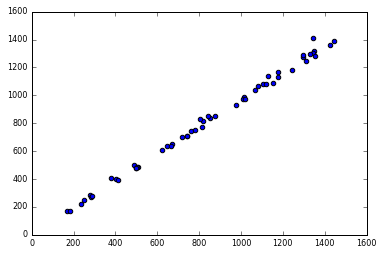

In [15]:
plt.scatter(metadata.loc[(metadata['Province']=='Quebec') &
                         (metadata['35TRGT Scenario']==1) ,\
                         ['Gross Energy (GWh)','Site ID #']]\
                         .set_index('Site ID #').values,
            (wdf.sum()/1000/3).values)

There are some differences but roughly the same

I erase the leap day of 2008 because it will mess up with my dayofyear grouping

In [16]:
wdf=wdf[~((wdf.index.month == 2) & (wdf.index.day == 29))]

Sum all sites, we are not interested in intra-site variability

In [17]:
wdfagg=wdf.sum(axis=1)

## calculate the average capacity factor per time slice 

### create a column with a tag indicating the time slice

we create a dataframe instead of a series because otherwise gives some problems adding extra columns

In [18]:
df_wdfagg=pd.DataFrame({'production':wdfagg})

In [19]:
df_wdfagg['season']='empty'

In [20]:
df_wdfagg.loc[(df_wdfagg.index.month==3) & (df_wdfagg.index.day>20),'season']='spring'
df_wdfagg.loc[(df_wdfagg.index.month==4),'season']='spring'
df_wdfagg.loc[(df_wdfagg.index.month==5),'season']='spring'
df_wdfagg.loc[(df_wdfagg.index.month==6) & (df_wdfagg.index.day<21),'season']='spring'

In [21]:
df_wdfagg.loc[(df_wdfagg.index.month==6) & (df_wdfagg.index.day>=21),'season']='summer'
df_wdfagg.loc[(df_wdfagg.index.month==7),'season']='summer'
df_wdfagg.loc[(df_wdfagg.index.month==8),'season']='summer'
df_wdfagg.loc[(df_wdfagg.index.month==9) & (df_wdfagg.index.day<21),'season']='summer'

In [22]:
df_wdfagg.loc[(df_wdfagg.index.month==9) & (df_wdfagg.index.day>=21),'season']='fall'
df_wdfagg.loc[(df_wdfagg.index.month==10),'season']='fall'
df_wdfagg.loc[(df_wdfagg.index.month==11),'season']='fall'
df_wdfagg.loc[(df_wdfagg.index.month==12) & (df_wdfagg.index.day<21),'season']='fall'

In [23]:
df_wdfagg.loc[(df_wdfagg.index.month==12) & (df_wdfagg.index.day>=21),'season']='winter'
df_wdfagg.loc[(df_wdfagg.index.month==1),'season']='winter'
df_wdfagg.loc[(df_wdfagg.index.month==2),'season']='winter'
df_wdfagg.loc[(df_wdfagg.index.month==3) & (df_wdfagg.index.day<21),'season']='winter'

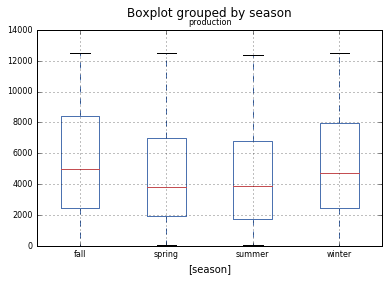

In [24]:
df_wdfagg.boxplot(by='season')

In [25]:
df_wdfagg['dailyts']='empty'

In [26]:
df_wdfagg.loc[(df_wdfagg.index.hour==6) | 
              (df_wdfagg.index.hour==7) | 
              (df_wdfagg.index.hour==8),'dailyts']='P1' 

df_wdfagg.loc[(df_wdfagg.index.hour==17) | 
              (df_wdfagg.index.hour==18) | 
              (df_wdfagg.index.hour==19),'dailyts']='P2' 

df_wdfagg.loc[(wdfagg.index.hour>8) & 
              (wdfagg.index.hour<17),'dailyts']='D' 

df_wdfagg.loc[(wdfagg.index.hour<6) |
              (wdfagg.index.hour>19),'dailyts']='N' 

Checking we don't have empty values

In [27]:
if len(df_wdfagg['dailyts'].unique())!=4:
    print('we have a problem')
else:
    print('all hours have a daily ts tag')

all hours have a daily ts tag


create a tag combining the seasonal and daily conditions

In [28]:
df_wdfagg['tstag']='empty' # initialise

In [29]:
df_wdfagg.loc[(df_wdfagg['dailyts']=='N') & (df_wdfagg['season']=='spring'),'tstag']='RN'
df_wdfagg.loc[(df_wdfagg['dailyts']=='N') & (df_wdfagg['season']=='summer'),'tstag']='SN'
df_wdfagg.loc[(df_wdfagg['dailyts']=='N') & (df_wdfagg['season']=='winter'),'tstag']='WN'
df_wdfagg.loc[(df_wdfagg['dailyts']=='N') & (df_wdfagg['season']=='fall'),'tstag']='FN'

df_wdfagg.loc[(df_wdfagg['dailyts']=='D') & (df_wdfagg['season']=='spring'),'tstag']='RD'
df_wdfagg.loc[(df_wdfagg['dailyts']=='D') & (df_wdfagg['season']=='summer'),'tstag']='SD'
df_wdfagg.loc[(df_wdfagg['dailyts']=='D') & (df_wdfagg['season']=='winter'),'tstag']='WD'
df_wdfagg.loc[(df_wdfagg['dailyts']=='D') & (df_wdfagg['season']=='fall'),'tstag']='FD'

df_wdfagg.loc[(df_wdfagg['dailyts']=='P1') & (df_wdfagg['season']=='spring'),'tstag']='RP1'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P1') & (df_wdfagg['season']=='summer'),'tstag']='SP1'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P1') & (df_wdfagg['season']=='winter'),'tstag']='WP1'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P1') & (df_wdfagg['season']=='fall'),'tstag']='FP1'

df_wdfagg.loc[(df_wdfagg['dailyts']=='P2') & (df_wdfagg['season']=='spring'),'tstag']='RP2'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P2') & (df_wdfagg['season']=='summer'),'tstag']='SP2'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P2') & (df_wdfagg['season']=='winter'),'tstag']='WP2'
df_wdfagg.loc[(df_wdfagg['dailyts']=='P2') & (df_wdfagg['season']=='fall'),'tstag']='FP2'

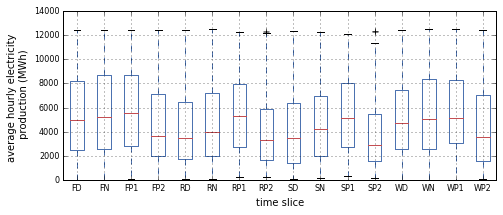

In [30]:
bp2=df_wdfagg.boxplot(by='tstag',figsize=(7,3))
bp2.set_title('')
bp2.set_xlabel('time slice')
bp2.set_ylabel('average hourly electricity \n production (MWh)')
plt.suptitle('')
plt.tight_layout()
plt.savefig('boxplot_wind.png',dpi=600,)

In [31]:
df_wdfagg.head()

,production,season,dailyts,tstag
Date/Time,,,,
2008-01-01 00:00:00,3397.957267,winter,N,WN
2008-01-01 01:00:00,4249.773235,winter,N,WN
2008-01-01 02:00:00,4883.350543,winter,N,WN
2008-01-01 03:00:00,5169.177240,winter,N,WN
2008-01-01 04:00:00,5388.262450,winter,N,WN


# calculation of capacity factors

the hourly capacity factor is the hourly aggregated production divided by the total capacity

In [32]:
df_wdfagg['CF']=df_wdfagg['production']/metadata.loc[(metadata['Province']=='Quebec') &
             (metadata['35TRGT Scenario']==1),'Capacity (MW)'].sum()

In [33]:
df_wdfagg['CF'].mean()

0.396176758207132

In [34]:
cf_avg_metadata=metadata.loc[(metadata['Province']=='Quebec') &
             (metadata['35TRGT Scenario']==1),'Capacity Factor (%)'].mean()

In [35]:
cf_avg_metadata

0.37749815255905556

The capacity factor in the metadata is slightly lower, maybe because of transmission and distribution losses. Just in case, we adjust the values so the average CF corresponds to the summary of the metadata.

In [36]:
df_wdfagg['CF2']=(df_wdfagg['CF']*cf_avg_metadata/df_wdfagg['CF'].mean())

In [37]:
df_wdfagg[['CF','CF2','tstag']].groupby('tstag').mean()

,CF,CF2
tstag,,
FD,0.438181,0.417522
FN,0.457169,0.435614
FP1,0.473116,0.450810
FP2,0.378074,0.360249
RD,0.344499,0.328257
RN,0.376761,0.358998
RP1,0.436327,0.415756
RP2,0.325859,0.310496
SD,0.328111,0.312642
